In [95]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

print("Setup Complete")

Setup Complete


# Introduction
We're going to use the dataset on [Kaggle](https://www.kaggle.com/datasets/federalreserve/interest-rates). It contains interest rate data since 1954. The federal funds rate is the interest rate at which banks trade federal funds overnight. The Fed sets a **target** for this, but due to the free market, the **effective** funds rate will be different. Since we're predicting the Fed's decision, we're going to predict the target rate.

According to the dataset description:
> The unemployment rate represents the number of unemployed as a seasonally adjusted percentage of the labor force. The inflation rate reflects the monthly change in the Consumer Price Index of products excluding food and energy.

In [96]:
df = pd.read_csv('index.csv')
df.head()

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN


# Data Cleaning
First, let's see how many missing values we have.

In [97]:
df.isnull().sum()

Year                              0
Month                             0
Day                               0
Federal Funds Target Rate       442
Federal Funds Upper Target      801
Federal Funds Lower Target      801
Effective Federal Funds Rate    152
Real GDP (Percent Change)       654
Unemployment Rate               152
Inflation Rate                  194
dtype: int64

### Federal Funds Upper/Lower Target
It looks like there are a lot of missing values in `Federal Funds Upper Target` and `Federal Funds Lower Target`. Since this range system was only adopted more recently, we can simply convert them back to single values by calculating their average. Also, there are way too many missing values in `Real GDP (Percent Change)` so we're just going to drop it.

In [98]:

df.loc[df['Federal Funds Target Rate'].isna(), 'Federal Funds Target Rate'] = (df['Federal Funds Upper Target'] + df[
    'Federal Funds Lower Target']) / 2
df = df.drop(['Federal Funds Upper Target', 'Federal Funds Lower Target', 'Real GDP (Percent Change)'], axis=1)

df.head()

,Year,Month,Day,Federal Funds Target Rate,Effective Federal Funds Rate,Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,0.80,5.8,NaN
1,1954,8,1,NaN,1.22,6.0,NaN
2,1954,9,1,NaN,1.06,6.1,NaN
3,1954,10,1,NaN,0.85,5.7,NaN
4,1954,11,1,NaN,0.83,5.3,NaN


### Federal Funds Target Rate, Unemployment Rate, Inflation Rate
Now, let's graph the number of missing `Federal Funds Target Rate`, `Unemployment Rate`, and `Inflation Rate` values by year.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

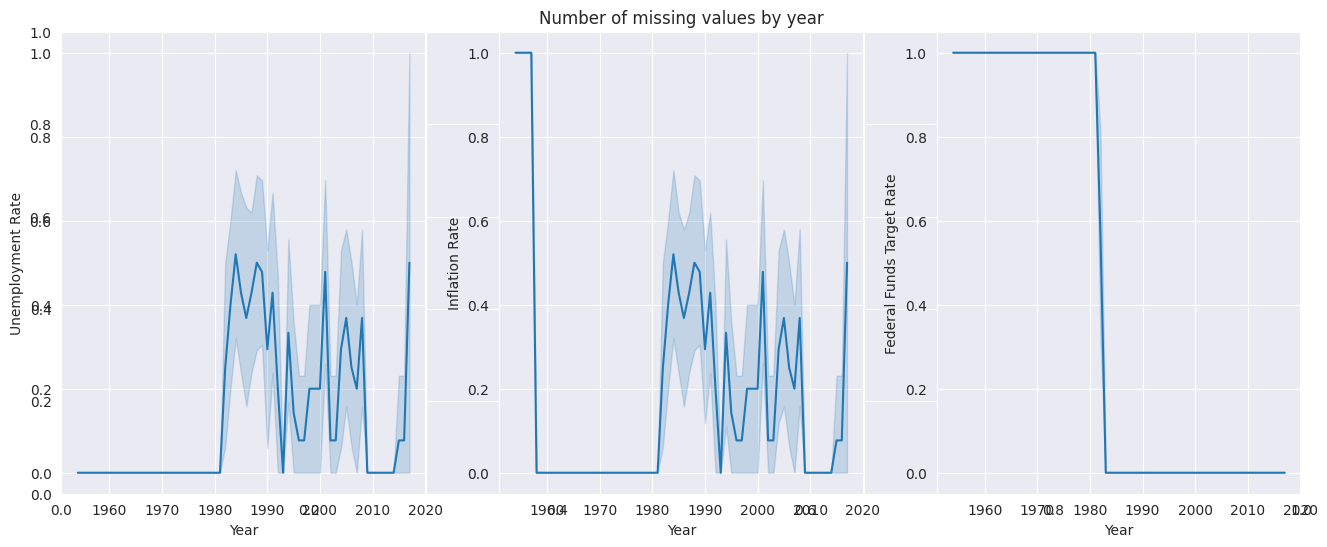

In [99]:
plt.figure(figsize=(16, 6))
plt.title('Number of missing values by year')
# plot 3 graphs separately
plt.subplot(1, 3, 1)
sns.lineplot(x=df['Year'], y=df['Unemployment Rate'].isnull())
plt.subplot(1, 3, 2)
sns.lineplot(x=df['Year'], y=df['Inflation Rate'].isnull())
plt.subplot(1, 3, 3)
sns.lineplot(x=df['Year'], y=df['Federal Funds Target Rate'].isnull())

plt.show()


It seems that the missing values for `Inflation Rate` and `Unemployment Rate` are very erratic, so we can probably just generically impute them later. 
### Effective Federal Funds Rate
However, for `Federal Funds Target Rate`, we can see that the missing values are mostly in the 1950s to the 1970s. Let's see if the years with missing values in `Federal Funds Target Rate` also have missing values in `Effective Federal Funds Rate`.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

<Axes: title={'center': 'Number of missing values by year'}, xlabel='Year', ylabel='Federal Funds Target Rate'>

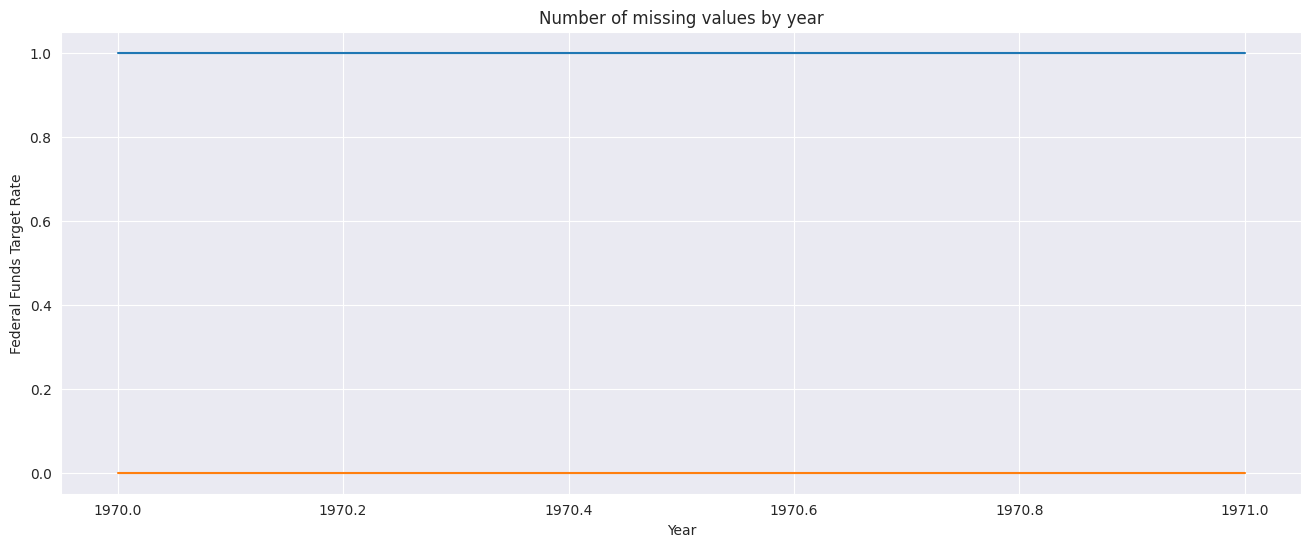

In [100]:
plt.figure(figsize=(16, 6))
plt.title('Number of missing values by year')
sns.lineplot(x=df['Year'], y=df.loc['1950':'1990', 'Federal Funds Target Rate'].isnull())
sns.lineplot(x=df['Year'], y=df.loc['1950':'1990', 'Effective Federal Funds Rate'].isnull())


In [101]:
df.loc[df['Federal Funds Target Rate'].isna(), 'Effective Federal Funds Rate'].notna().sum() / df[
    'Federal Funds Target Rate'].isna().sum()


1.0

It looks like values in `Effective Federal Funds Rate` are always present if the values from `Federal Funds Target Rate` are missing. Therefore, we can just impute the missing values in `Federal Funds Target Rate` with the values in `Effective Federal Funds Rate`, since they are usually very close to each other.

In [102]:
df.loc[df['Federal Funds Target Rate'].isna(), 'Federal Funds Target Rate'] = df.loc[
    df['Federal Funds Target Rate'].isna(), 'Effective Federal Funds Rate']

df.isnull().sum()

Year                              0
Month                             0
Day                               0
Federal Funds Target Rate         0
Effective Federal Funds Rate    152
Unemployment Rate               152
Inflation Rate                  194
dtype: int64

Since we're not going to know what the `Effective Federal Funds Rate` is when predicting in the real world, we can drop that column now.

In [103]:
df = df.drop('Effective Federal Funds Rate', axis=1)
df.isnull().sum()

Year                           0
Month                          0
Day                            0
Federal Funds Target Rate      0
Unemployment Rate            152
Inflation Rate               194
dtype: int64

All that's left is to impute the missing values in `Inflation Rate` and `Unemployment Rate`. We can't derive these values from the existing data, so we'll just use the mean of the previous and next values.

In [104]:
df['Inflation Rate'] = df['Inflation Rate'].interpolate()
df['Unemployment Rate'] = df['Unemployment Rate'].interpolate()
df.isnull().sum()

Year                          0
Month                         0
Day                           0
Federal Funds Target Rate     0
Unemployment Rate             0
Inflation Rate               42
dtype: int64

Let's see where these 42 missing `Inflation Rate` values are.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

<Axes: xlabel='Year', ylabel='Inflation Rate'>

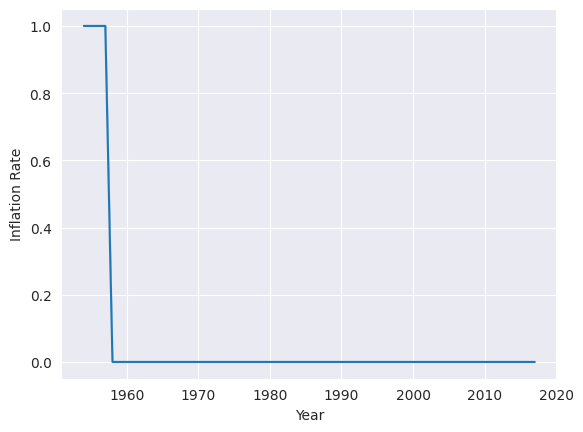

In [105]:
sns.lineplot(x=df['Year'], y=df['Inflation Rate'].isna())

Looks like inflation data wasn't tracked in the 1950s. Since there's only 42 rows and I really want to measure with inflation rate, let's just drop them.

In [106]:
df = df.dropna(subset=['Inflation Rate'])

df.isnull().sum()

Year                         0
Month                        0
Day                          0
Federal Funds Target Rate    0
Unemployment Rate            0
Inflation Rate               0
dtype: int64

# Data Analysis & Feature Engineering

## Interest Rate Fluctuations
Certain periods, such as the 1980s oil crisis, caused interest rates to spike much higher than normal. Additionally, after around 2008, the US adopted a different strategy for hikes.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

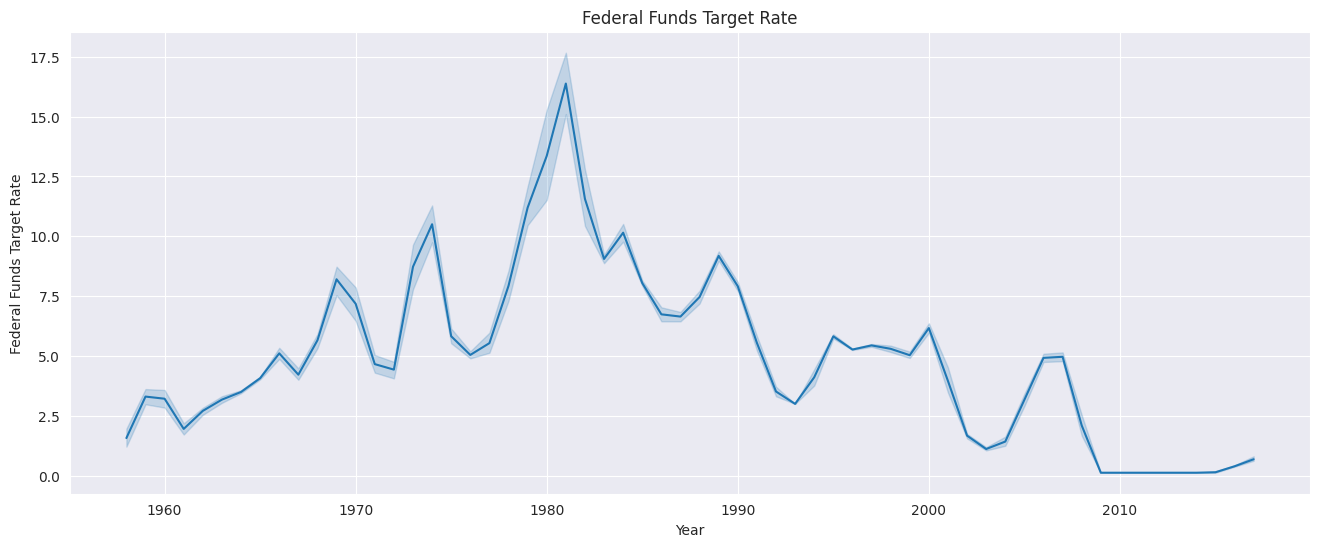

In [107]:
plt.figure(figsize=(16, 6))
sns.lineplot(x=df['Year'], y=df['Federal Funds Target Rate'])
plt.title('Federal Funds Target Rate')
plt.show()

## Correlations

We now only have two columns to predict from: `Unemployment Rate` and `Inflation Rate`. Let's see how they correlate with the `Federal Funds Target Rate`.

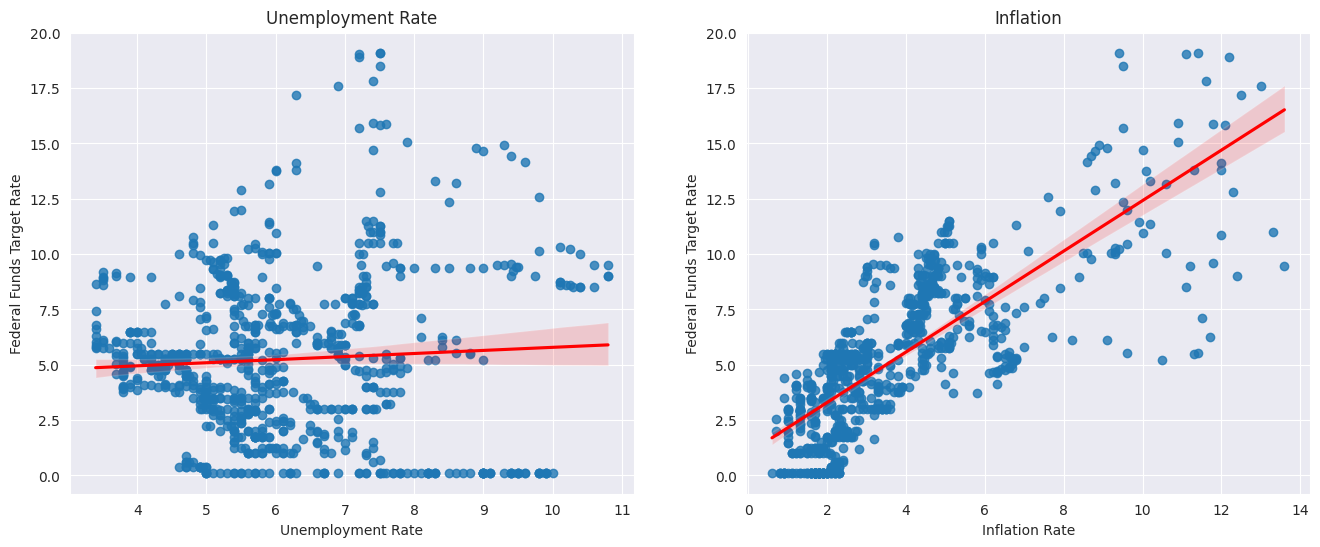

In [108]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.regplot(x=df['Unemployment Rate'], y=df['Federal Funds Target Rate'], line_kws={'color': 'red'})
plt.title('Unemployment Rate')
plt.subplot(122)
sns.regplot(x=df['Inflation Rate'], y=df['Federal Funds Target Rate'], line_kws={'color': 'red'})
plt.title('Inflation')
plt.show()


It looks like `Unemployment Rate` is barely correlated with `Federal Funds Target Rate`, but `Inflation Rate` is very correlated. This makes sense, since the Fed's main goal is to keep inflation low. 

In general, we shouldn't have correlated features in the dataset. Let's see how the two features correlate with each other.

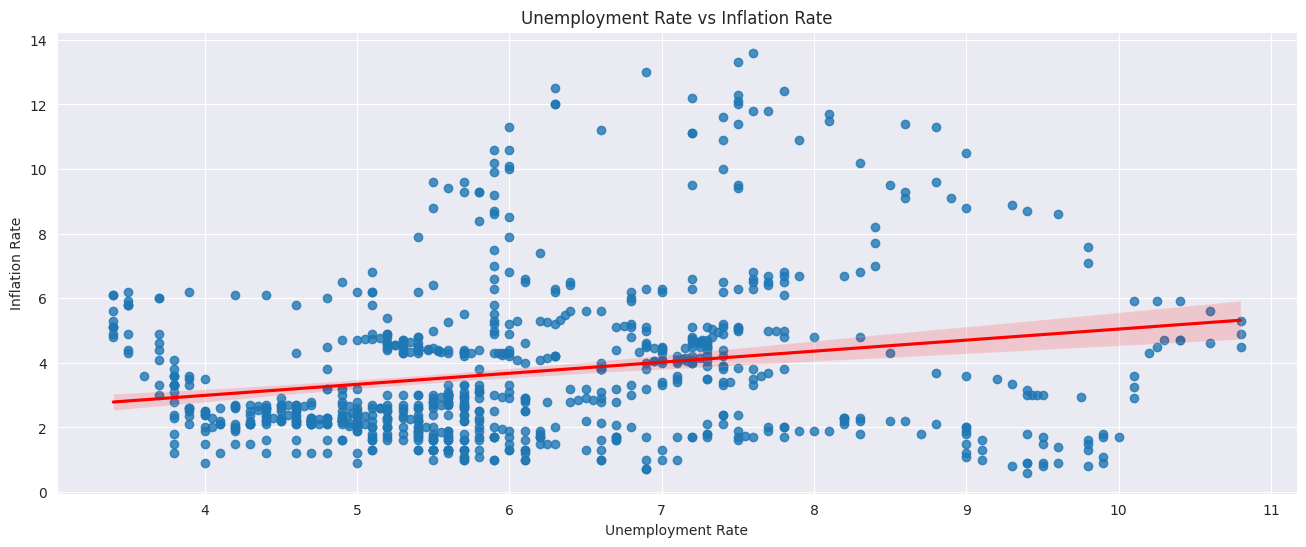

In [109]:
plt.figure(figsize=(16, 6))
sns.regplot(x=df['Unemployment Rate'], y=df['Inflation Rate'], line_kws={'color': 'red'})
plt.title('Unemployment Rate vs Inflation Rate')
plt.show()

In [110]:
df = df.loc[df['Year'] >= 2008]

The correlation is very weak. Thus, both features still contribute to the model. We will not drop anything.

## Data Binning
Let's see how the time values are distributed; particiularly, the day column.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

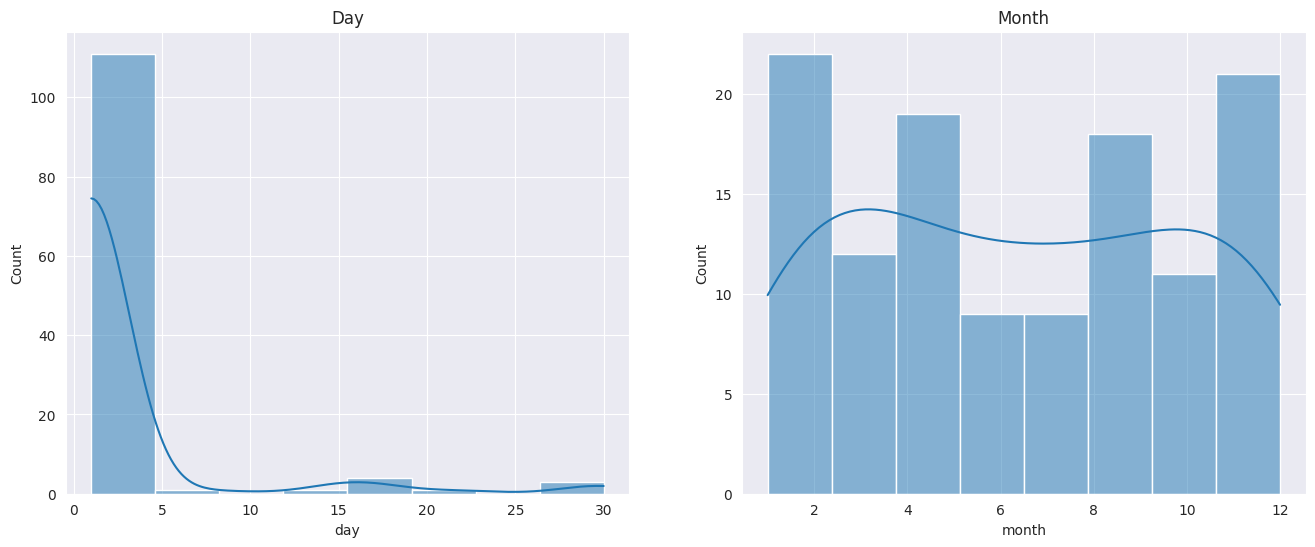

In [111]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.histplot(df['Day'], kde=True)
plt.title('Day')
plt.xlabel('day')
plt.subplot(122)
sns.histplot(df['Month'], kde=True)
plt.xlabel('month')
plt.title('Month')
plt.show()


It looks like the Fed meets pretty consistently every month, but more during the later part of the year. In addition, most of the meetings are on the 1st day of the month. In order to ensure the times of the data are evenly spaced, let's group the data by month/year, taking the average of each bin.

Now that the data is uniform over time, we don't need the `Day`, `Month`, or `Year` columns anymore.

In [112]:
print('Pre-binning shape: ', df.shape)
df = df.groupby(['Year', 'Month'], as_index=False).mean()
df = df.drop('Day', axis=1).drop('Month', axis=1).drop('Year', axis=1) # useless now that we've binned
print('Post-binning shape: ', df.shape)

df.head()

Pre-binning shape:  (121, 6)
Post-binning shape:  (111, 3)


,Federal Funds Target Rate,Unemployment Rate,Inflation Rate
0,3.583333,4.966667,2.433333
1,3.000000,4.900000,2.300000
2,2.625000,5.075000,2.375000
3,2.125000,5.100000,2.300000
4,2.000000,5.400000,2.300000


## Stationarity
It's important to account for any seasonalities/trends in the data. Let's use the ACF (autocorrelation function) and PACF (partial autocorrelation function) graphs to see how dependent our target variable specifically is on time.

<Figure size 1600x600 with 0 Axes>

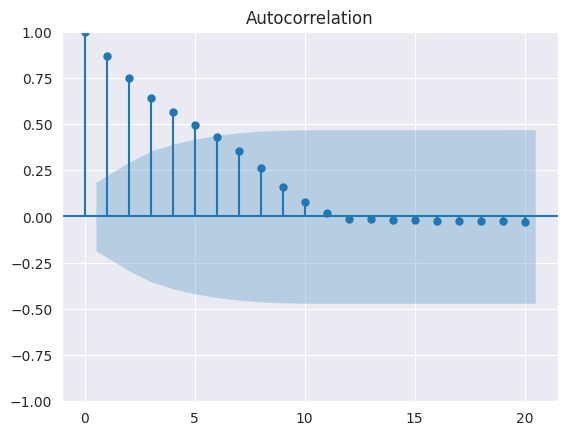

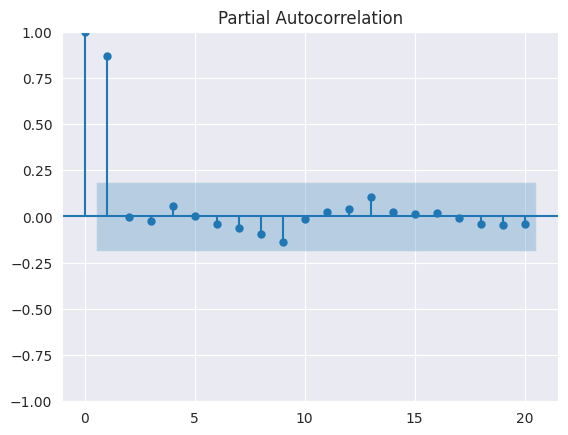

In [113]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(16, 6))
plot_acf(df['Federal Funds Target Rate'], lags=20)
plot_pacf(df['Federal Funds Target Rate'], lags=20)
plt.show()

According to the PACF graph, the first few lags are very significant, meaning that the data is extremely non-stationary. Let's get to work.

Let's graph our features and target columns first:

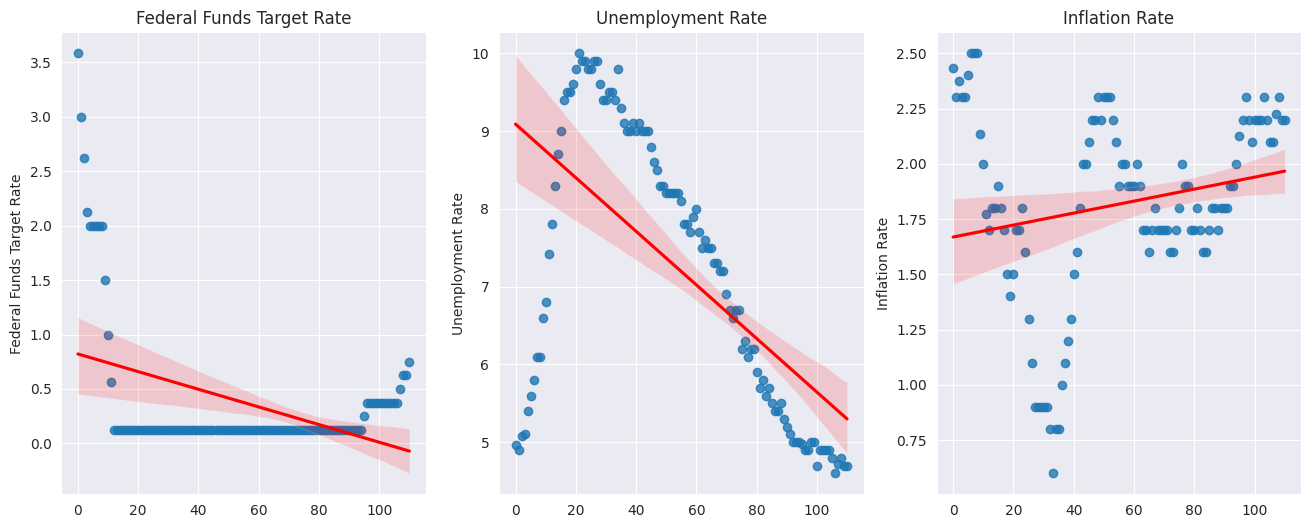

In [114]:
plt.figure(figsize=(16, 6))
plt.subplot(131)
sns.regplot(x=df.index, y=df['Federal Funds Target Rate'], line_kws={'color': 'red'})
plt.title('Federal Funds Target Rate')
plt.subplot(132)
sns.regplot(x=df.index, y=df['Unemployment Rate'], line_kws={'color': 'red'})
plt.title('Unemployment Rate')
plt.subplot(133)
sns.regplot(x=df.index, y=df['Inflation Rate'], line_kws={'color': 'red'})
plt.title('Inflation Rate')
plt.show()

Since the features have temporal trends, let's difference the data to remove them.

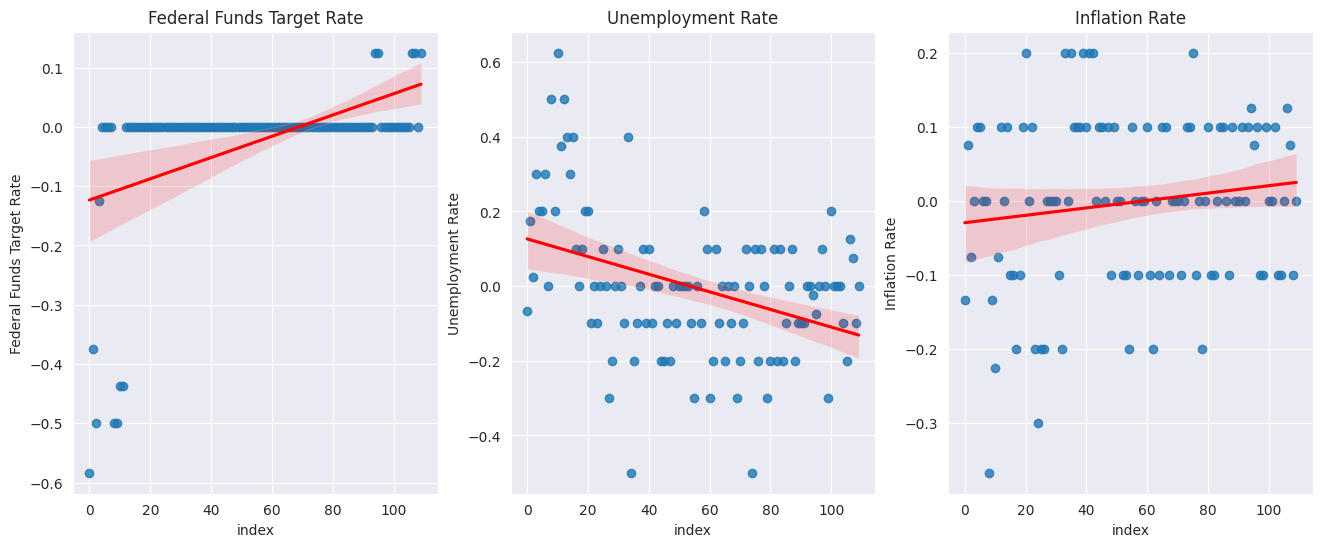

In [115]:
inflation_diff = df['Inflation Rate'].diff().dropna()
unemployment_diff = df['Unemployment Rate'].diff().dropna()
interest_diff = df['Federal Funds Target Rate'].diff().dropna()
indexes = df.reset_index()['index'].shift(1).dropna()
plt.figure(figsize=(16, 6))
plt.subplot(131)
sns.regplot(x=indexes, y=interest_diff, line_kws={'color': 'red'})
plt.title('Federal Funds Target Rate')
plt.subplot(132)
sns.regplot(x=indexes, y=unemployment_diff, line_kws={'color': 'red'})
plt.title('Unemployment Rate')
plt.subplot(133)
sns.regplot(x=indexes, y=inflation_diff, line_kws={'color': 'red'})
plt.title('Inflation Rate')
plt.show()

Let's double-check the stationarity of both data by running the augmented Dickey-Fuller test.

In [116]:
from statsmodels.tsa.stattools import adfuller
for e in [interest_diff, unemployment_diff, inflation_diff]:
    print('ADF value: ', adfuller(e.values)[0])
    print('p-value: ', adfuller(e.values)[1])
    print('Critical Values: ', adfuller(e.values)[4])
    print("------")




ADF value:  -5.525261449674613
p-value:  1.8388552859820108e-06
Critical Values:  {'1%': -3.49181775886872, '5%': -2.8884437992971588, '10%': -2.5811201893779985}
------
ADF value:  -1.9292298621733264
p-value:  0.3184378343211416
Critical Values:  {'1%': -3.4948504603223145, '5%': -2.889758398668639, '10%': -2.5818220155325444}
------
ADF value:  -2.788777403330082
p-value:  0.05989480410440954
Critical Values:  {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}
------


Since the ADF value is less than the critical value and the p-values <= 0.05, we can reject the null hypothesis that the data is non-stationary. Thus, we can use the differenced data.

In [117]:
original_first_interest = df['Federal Funds Target Rate'].iloc[0]
df['Federal Funds Target Rate'] = interest_diff
df['Unemployment Rate'] = unemployment_diff
df['Inflation Rate'] = inflation_diff
df = df.tail(-1)
df = df.dropna()
df.head()

,Federal Funds Target Rate,Unemployment Rate,Inflation Rate
1,-0.583333,-0.066667,-0.133333
2,-0.375000,0.175000,0.075000
3,-0.500000,0.025000,-0.075000
4,-0.125000,0.300000,0.000000
5,0.000000,0.200000,0.100000


Let's take a look at the PACF and ACF graphs again:

<Figure size 1600x600 with 0 Axes>

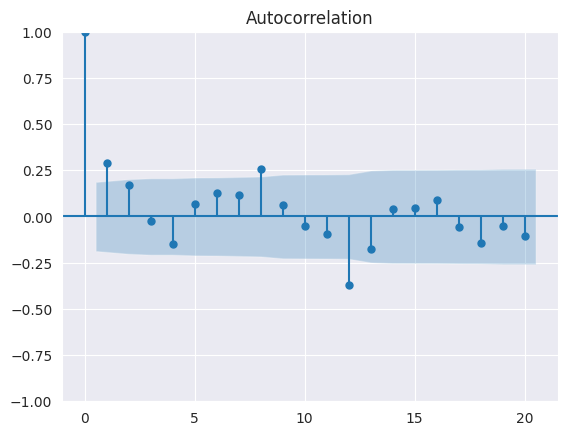

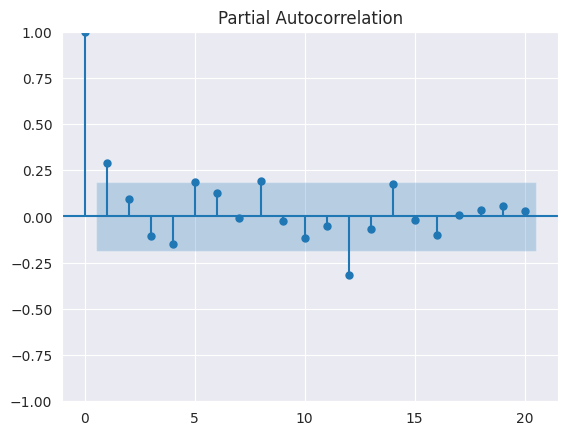

In [118]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(16, 6))
plot_acf(df['Inflation Rate'], lags=20)
plot_pacf(df['Inflation Rate'], lags=20)
plt.show()

The autocorrelation is much lower now! We can move on.

## Lag Features
Let's add lag features (they're very important for time-series data). We will not lag `Federal Funds Target Rate`. This is because doing would mess up the shape of our data (eg. it would be 3x12 for the lagged features, and then we would have the 2 values for this month's inflation and unemployment; resulting in a 3x13 rectangle with 1 cell missing)

In [119]:
for i in range(11, 0, -1):
    df[f'Inflation Rate Lag - {i}'] = df['Inflation Rate'].shift(i)
    df[f'Unemployment Rate Lag - {i}'] = df['Unemployment Rate'].shift(i)
df['Inflation Rate'] = df.pop('Inflation Rate')
df['Unemployment Rate'] = df.pop('Unemployment Rate')
df = df.dropna()
df.head()

,Federal Funds Target Rate,Inflation Rate Lag - 11,Unemployment Rate Lag - 11,Inflation Rate Lag - 10,Unemployment Rate Lag - 10,Inflation Rate Lag - 9,Unemployment Rate Lag - 9,Inflation Rate Lag - 8,Unemployment Rate Lag - 8,Inflation Rate Lag - 7,...,Inflation Rate Lag - 4,Unemployment Rate Lag - 4,Inflation Rate Lag - 3,Unemployment Rate Lag - 3,Inflation Rate Lag - 2,Unemployment Rate Lag - 2,Inflation Rate Lag - 1,Unemployment Rate Lag - 1,Inflation Rate,Unemployment Rate
12,-0.4375,-0.133333,-0.066667,0.075,0.175,-0.075,0.025,0.0,0.3,0.100000,...,0.000000,0.000,-0.366667,0.500,-0.133333,0.200,-0.225,0.625,-0.075,0.375
13,0.0000,0.075000,0.175000,-0.075,0.025,0.000,0.300,0.1,0.2,0.100000,...,-0.366667,0.500,-0.133333,0.200,-0.225000,0.625,-0.075,0.375,0.100,0.500
14,0.0000,-0.075000,0.025000,0.000,0.300,0.100,0.200,0.1,0.2,0.000000,...,-0.133333,0.200,-0.225000,0.625,-0.075000,0.375,0.100,0.500,0.000,0.400
15,0.0000,0.000000,0.300000,0.100,0.200,0.100,0.200,0.0,0.3,0.000000,...,-0.225000,0.625,-0.075000,0.375,0.100000,0.500,0.000,0.400,0.100,0.300
16,0.0000,0.100000,0.200000,0.100,0.200,0.000,0.300,0.0,0.0,-0.366667,...,-0.075000,0.375,0.100000,0.500,0.000000,0.400,0.100,0.300,-0.100,0.400


## Scaling Values
For LSTM, we need to scale the values. We'll use the min-max scaler since it's the most common.

In [120]:
from sklearn.preprocessing import MinMaxScaler
# find number of zeros in federal funds targe rate
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
df['Inflation Rate'] = x_scaler.fit_transform(df[['Inflation Rate']])
df['Unemployment Rate'] = x_scaler.fit_transform(df[['Unemployment Rate']])
for i in range(1, 12):
    df[f'Inflation Rate Lag - {i}'] = x_scaler.fit_transform(df[[f'Inflation Rate Lag - {i}']])
    df[f'Unemployment Rate Lag - {i}'] = x_scaler.fit_transform(df[[f'Unemployment Rate Lag - {i}']])
df['Federal Funds Target Rate'] = y_scaler.fit_transform(df[['Federal Funds Target Rate']])

df.head()

,Federal Funds Target Rate,Inflation Rate Lag - 11,Unemployment Rate Lag - 11,Inflation Rate Lag - 10,Unemployment Rate Lag - 10,Inflation Rate Lag - 9,Unemployment Rate Lag - 9,Inflation Rate Lag - 8,Unemployment Rate Lag - 8,Inflation Rate Lag - 7,...,Inflation Rate Lag - 4,Unemployment Rate Lag - 4,Inflation Rate Lag - 3,Unemployment Rate Lag - 3,Inflation Rate Lag - 2,Unemployment Rate Lag - 2,Inflation Rate Lag - 1,Unemployment Rate Lag - 1,Inflation Rate,Unemployment Rate
12,0.000000,0.411765,0.385185,0.779412,0.600000,0.514706,0.466667,0.647059,0.711111,0.823529,...,0.647059,0.444444,0.000000,0.888889,0.333333,0.622222,0.15,1.000000,0.45,0.875
13,0.777778,0.779412,0.600000,0.514706,0.466667,0.647059,0.711111,0.823529,0.622222,0.823529,...,0.000000,0.888889,0.411765,0.622222,0.150000,1.000000,0.45,0.777778,0.80,1.000
14,0.777778,0.514706,0.466667,0.647059,0.711111,0.823529,0.622222,0.823529,0.622222,0.647059,...,0.411765,0.622222,0.250000,1.000000,0.450000,0.777778,0.80,0.888889,0.60,0.900
15,0.777778,0.647059,0.711111,0.823529,0.622222,0.823529,0.622222,0.647059,0.711111,0.647059,...,0.250000,1.000000,0.514706,0.777778,0.800000,0.888889,0.60,0.800000,0.80,0.800
16,0.777778,0.823529,0.622222,0.823529,0.622222,0.647059,0.711111,0.647059,0.444444,0.000000,...,0.514706,0.777778,0.823529,0.888889,0.600000,0.800000,0.80,0.711111,0.40,0.900


There's not much else to do, since the data is all numerical and there aren't many columns. We can now move on to model building.

# Model Building

## Final Data Validation
Let's run a few checks to ensure there are no nan values and no inf values.

In [121]:
print(df.isnull().sum().sum())
print(df.isin([np.inf, -np.inf]).sum().sum())
df.head()

0
0


,Federal Funds Target Rate,Inflation Rate Lag - 11,Unemployment Rate Lag - 11,Inflation Rate Lag - 10,Unemployment Rate Lag - 10,Inflation Rate Lag - 9,Unemployment Rate Lag - 9,Inflation Rate Lag - 8,Unemployment Rate Lag - 8,Inflation Rate Lag - 7,...,Inflation Rate Lag - 4,Unemployment Rate Lag - 4,Inflation Rate Lag - 3,Unemployment Rate Lag - 3,Inflation Rate Lag - 2,Unemployment Rate Lag - 2,Inflation Rate Lag - 1,Unemployment Rate Lag - 1,Inflation Rate,Unemployment Rate
12,0.000000,0.411765,0.385185,0.779412,0.600000,0.514706,0.466667,0.647059,0.711111,0.823529,...,0.647059,0.444444,0.000000,0.888889,0.333333,0.622222,0.15,1.000000,0.45,0.875
13,0.777778,0.779412,0.600000,0.514706,0.466667,0.647059,0.711111,0.823529,0.622222,0.823529,...,0.000000,0.888889,0.411765,0.622222,0.150000,1.000000,0.45,0.777778,0.80,1.000
14,0.777778,0.514706,0.466667,0.647059,0.711111,0.823529,0.622222,0.823529,0.622222,0.647059,...,0.411765,0.622222,0.250000,1.000000,0.450000,0.777778,0.80,0.888889,0.60,0.900
15,0.777778,0.647059,0.711111,0.823529,0.622222,0.823529,0.622222,0.647059,0.711111,0.647059,...,0.250000,1.000000,0.514706,0.777778,0.800000,0.888889,0.60,0.800000,0.80,0.800
16,0.777778,0.823529,0.622222,0.823529,0.622222,0.647059,0.711111,0.647059,0.444444,0.000000,...,0.514706,0.777778,0.823529,0.888889,0.600000,0.800000,0.80,0.711111,0.40,0.900


## Train/Validation/Test Split
First, we'll split the data. I'll do a traditional 80/20 split. Since I don't plan on tuning many hyperparameters, we're not going to include a validation set. We also have to keep the data in order since it's time-series data.

In [122]:

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, shuffle=False)
train.shape

(79, 25)

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

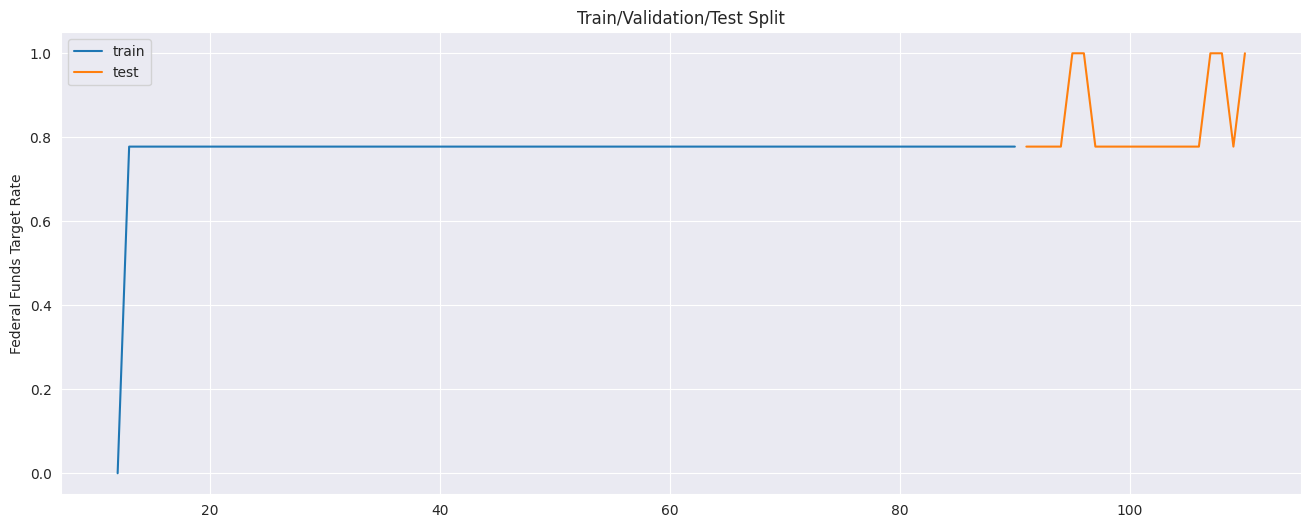

(79, 12, 2) (20, 12, 2)


In [123]:
plt.figure(figsize=(16, 6))
sns.lineplot(train['Federal Funds Target Rate'], label='train')
sns.lineplot(test['Federal Funds Target Rate'], label='test')
plt.title('Train/Validation/Test Split')
plt.legend()
plt.show()
x_train, y_train = train.drop('Federal Funds Target Rate', axis=1), train['Federal Funds Target Rate']
x_train = x_train.to_numpy().reshape(-1, 12, 2)
y_train = y_train.to_numpy().reshape(-1, 1, 1)
x_test, y_test = test.drop('Federal Funds Target Rate', axis=1), test['Federal Funds Target Rate']
x_test = x_test.to_numpy().reshape(-1, 12, 2)
y_test = y_test.to_numpy().reshape(-1, 1, 1)
print(x_train.shape, x_test.shape)

## Defining the Model
Now let's define the model. We're going to use recurrent neural networks (RNNs) since they work very well with time-series data. We'll use long short-term memory (LSTM) layers since they're the most popular and are pretty accurate. We'll also use dropout layers to prevent overfitting.

In [124]:
from keras.src.layers import LSTM, Dense, Dropout
from keras import Sequential, Input
model = Sequential([
    Input(shape=(x_train.shape[1], x_train.shape[2])),
    LSTM(512, return_sequences=True),
    Dropout(0.2),
    LSTM(256, return_sequences=True),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 12, 512)           1054720   
                                                                 
 dropout_8 (Dropout)         (None, 12, 512)           0         
                                                                 
 lstm_9 (LSTM)               (None, 12, 256)           787456    
                                                                 
 dropout_9 (Dropout)         (None, 12, 256)           0         
                                                                 
 lstm_10 (LSTM)              (None, 12, 128)           197120    
                                                                 
 dropout_10 (Dropout)        (None, 12, 128)           0         
                                                                 
 lstm_11 (LSTM)              (None, 64)               

## Training the Model
Now let's train the model. After fitting, we'll graph the mean squared error (MSE) to see how well the model did.

Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: nan
Epoch 2/1000
1/1 [==============================] - 0s 92ms/step - loss: nan
Epoch 3/1000
1/1 [==============================] - 0s 100ms/step - loss: nan
Epoch 4/1000
1/1 [==============================] - 0s 59ms/step - loss: nan
Epoch 5/1000
1/1 [==============================] - 0s 23ms/step - loss: nan
Epoch 6/1000
1/1 [==============================] - 0s 29ms/step - loss: nan
Epoch 7/1000
1/1 [==============================] - 0s 26ms/step - loss: nan
Epoch 8/1000
1/1 [==============================] - 0s 24ms/step - loss: nan
Epoch 9/1000
1/1 [==============================] - 0s 23ms/step - loss: nan
Epoch 10/1000
1/1 [==============================] - 0s 22ms/step - loss: nan
Epoch 11/1000
1/1 [==============================] - 0s 21ms/step - loss: nan
Epoch 12/1000
1/1 [==============================] - 0s 21ms/step - loss: nan
Epoch 13/1000
1/1 [==============================] - 0s 21ms/step - loss: 

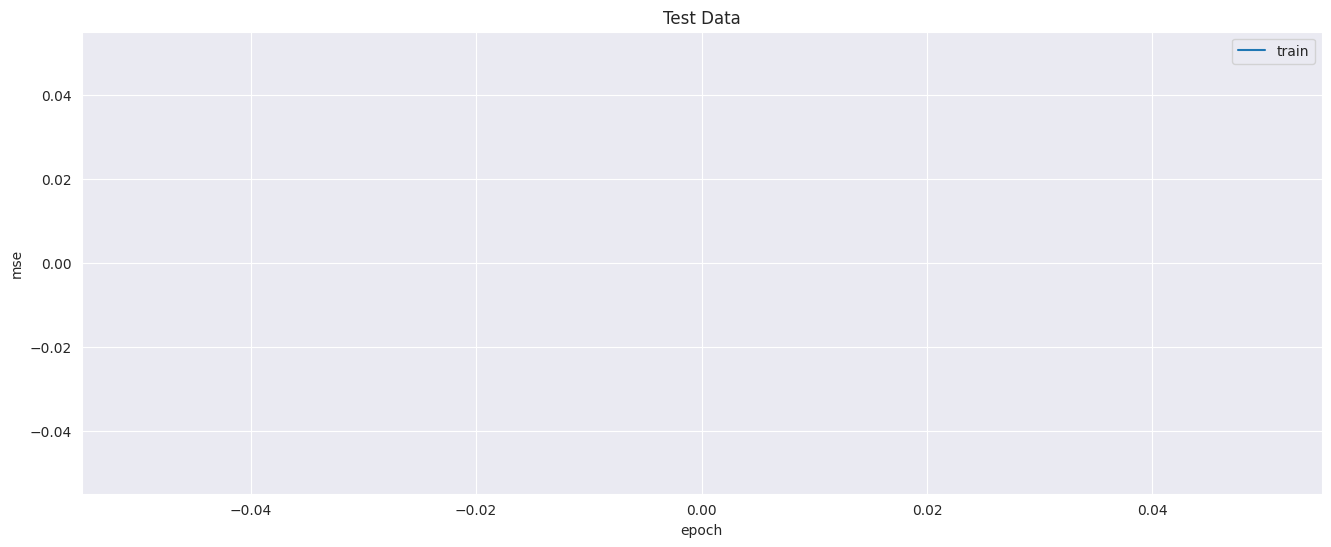

In [125]:
model.fit(x_train, y_train, epochs=1000, batch_size=128, verbose=1)

plt.figure(figsize=(16, 6))
plt.title('Test Data')
plt.plot(model.history.history['loss'], label='train')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.legend()
plt.show()

We'll also graph the actual and predicted values to see how close the model was. This is where we'll undo the normalization to get real-world values.
# Results
## Test Set Performance

1/1 [==============================] - 0s 23ms/step
nan nan


/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

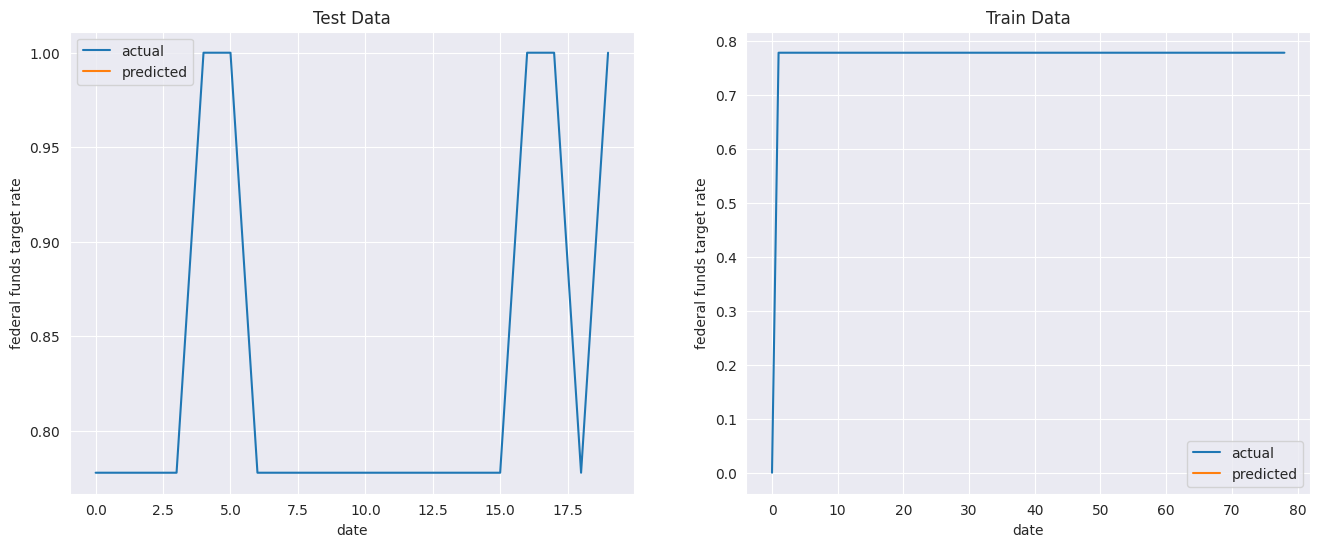

In [126]:
train_pred = model.predict(x_train).flatten()
test_pred = model.predict(x_test).flatten()

print(train_pred.min(), train_pred.max())

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title('Test Data')
sns.lineplot(y_test.flatten(), label='actual')
sns.lineplot(test_pred, label='predicted')
plt.xlabel('date')
plt.ylabel('federal funds target rate')
plt.legend()
plt.subplot(122)
plt.title('Train Data')
sns.lineplot(y_train.flatten(), label='actual')
sns.lineplot(train_pred, label='predicted')
plt.xlabel('date')
plt.ylabel('federal funds target rate')
plt.legend()
plt.show()